### Spatial Autocorrelation on Scraped Data at the Address/Point Level
  - Notable Changes
    - binary dependent variable -> Moran's I is still useful at local and global levels, but it may be helpful to combine this with joint count statistics.


In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import pysal.model as pm
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn
from splot.esda import plot_moran, lisa_cluster
import contextily as cx

/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
/Users/kendall/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. Se

#### Step 1: Import Data

In [2]:
scraped_data = gpd.read_file("scraped_data.geojson")

In [3]:
scraped_data = scraped_data.dropna()
len(scraped_data)

2606

In [4]:
scraped_data.crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [5]:
display(scraped_data.head())

,address_ID,address,lat,lon,block_geoid,population,population_error,has_FTTH,geometry
0,10886721,"7331 North HONORE Street, CHICAGO, IL 60626",42.014683,-87.676228,170310102012,1621.0,818.0,0,POINT (-87.676 42.015)
1,10888120,"7411 North CLARK Street, CHICAGO, IL 60626",42.016408,-87.675060,170310102021,1354.0,306.0,0,POINT (-87.675 42.016)
2,10889247,"7308 North PAULINA Street, CHICAGO, IL 60626",42.014176,-87.672644,170310102022,1511.0,471.0,0,POINT (-87.673 42.014)
3,10890447,"7589 North SHERIDAN Road, CHICAGO, IL 60626",42.019106,-87.665409,170310103002,2819.0,1008.0,0,POINT (-87.665 42.019)
4,10890425,"7579 North SHERIDAN Road, CHICAGO, IL 60626",42.019088,-87.665409,170310103002,2819.0,1008.0,0,POINT (-87.665 42.019)


#### Step 2: Spatial Weights
 - Kernel weight -> kernel function (rate/shape of decay in weight as distance from focal point increases) and bandwidth (distance over which the kernel function is applied...larger distances have a weight of zero)
    - bandwidth is more influential according to Mora-Garcia et al., 2015
    - adaptive bandwidth (different bandwidth for each observation) -> necessary for cases in which the density of observations varies across the region of interest
      - explicitly incorporates Tobler's Law
      - costly operation (considers every pair of distances)
      - NOTE: try differernt bandwidth values to find ideal -- balance between creating disperse bumps that make pattern detection difficult and oversmoothing/obscuring variation of observations in the region (see conclusion of Mora-Garcia et al., 2015)
        - a bandwidth of 10 spatial units was reasonable in this paper. try bandwidths of 5, 10, 15, and 20 to see which autocorrelation results are the best
- Note: accounting for the curvature of the earth is not necessary at this scale

In [6]:
w_adapt = weights.distance.Kernel.from_dataframe(
    scraped_data, k=84, fixed=False, function="gaussian"
)

In [7]:
w_adapt.transform = "R"

#### Step 3: Spatial Lag Term
- allows for comparison between a spatial unit and its neighbors (spatial lag is the average value of an observation among the neighbors of a focus point/unit)
- in the case of the binary data with point geometries, it represents the proportion of neighboring observations that have FTTH 

In [8]:
scraped_data["has_FTTH_lag"] = weights.spatial_lag.lag_spatial(w_adapt, scraped_data["has_FTTH"])

In [9]:
display(scraped_data)

,address_ID,address,lat,lon,block_geoid,population,population_error,has_FTTH,geometry,has_FTTH_lag
0,10886721,"7331 North HONORE Street, CHICAGO, IL 60626",42.014683,-87.676228,170310102012,1621.0,818.0,0,POINT (-87.676 42.015),0.000000
1,10888120,"7411 North CLARK Street, CHICAGO, IL 60626",42.016408,-87.675060,170310102021,1354.0,306.0,0,POINT (-87.675 42.016),0.000000
2,10889247,"7308 North PAULINA Street, CHICAGO, IL 60626",42.014176,-87.672644,170310102022,1511.0,471.0,0,POINT (-87.673 42.014),0.000000
3,10890447,"7589 North SHERIDAN Road, CHICAGO, IL 60626",42.019106,-87.665409,170310103002,2819.0,1008.0,0,POINT (-87.665 42.019),0.000000
4,10890425,"7579 North SHERIDAN Road, CHICAGO, IL 60626",42.019088,-87.665409,170310103002,2819.0,1008.0,0,POINT (-87.665 42.019),0.000000
...,...,...,...,...,...,...,...,...,...,...
2601,10852182,"5831 North CHRISTIANA Avenue, CHICAGO, IL 60659",41.987613,-87.712399,170311303003,1810.0,556.0,1,POINT (-87.712 41.988),0.228879
2602,10846179,"5607 North SAINT LOUIS Avenue, CHICAGO, IL 60659",41.983289,-87.715969,170311303004,2101.0,570.0,0,POINT (-87.716 41.983),0.338289
2603,10822730,"4957 North WHIPPLE Street, CHICAGO, IL 60625",41.971980,-87.704690,170311401001,1784.0,559.0,0,POINT (-87.705 41.972),0.401635
2604,10821881,"4928 North WHIPPLE Street, CHICAGO, IL 60625",41.971166,-87.705152,170311401001,1784.0,559.0,1,POINT (-87.705 41.971),0.413236


#### Step 4: Global Autocorrelation

In [10]:
# Moran Plot -> variable of interest is displayed against its spatial lag
# see resource: https://lanselin.github.io/introbook_vol1/morans-i.html


In [11]:
def standardize_binary(y):
    p = np.mean(y)
    return (y - p) / np.sqrt(p * (1 - p))

# Apply to your data
scraped_data['has_FTTH_std'] = standardize_binary(scraped_data['has_FTTH'])
scraped_data['has_FTTH_lag_std'] = standardize_binary(scraped_data['has_FTTH_lag'])
# Then use this standardized column for your Moran's I calculation

In [12]:
display(scraped_data.sample(5))

,address_ID,address,lat,lon,block_geoid,population,population_error,has_FTTH,geometry,has_FTTH_lag,has_FTTH_std,has_FTTH_lag_std
906,10452393,"7355 South ASHLAND Avenue, CHICAGO, IL 60636",41.759615,-87.663285,170316719001,1034.0,285.0,0,POINT (-87.663 41.760),0.047576,-0.529113,-0.415823
112,10653289,"116 West CHESTNUT Street, CHICAGO, IL 60610",41.898128,-87.632102,170310810002,2023.0,477.0,0,POINT (-87.632 41.898),0.014378,-0.529113,-0.495994
774,10321341,"11921 South WALLACE Street, CHICAGO, IL 60628",41.677204,-87.636793,170315305011,972.0,650.0,0,POINT (-87.637 41.677),0.000000,-0.529113,-0.530717
1688,10745564,"2826 West FLETCHER Street, CHICAGO, IL 60618",41.938643,-87.698917,170312108001,1142.0,189.0,1,POINT (-87.699 41.939),0.425528,1.889955,0.496916
2236,10543004,"5052 South LAFLIN Street, CHICAGO, IL 60609",41.801670,-87.662551,170316112002,1228.0,398.0,0,POINT (-87.663 41.802),0.008674,-0.529113,-0.509770


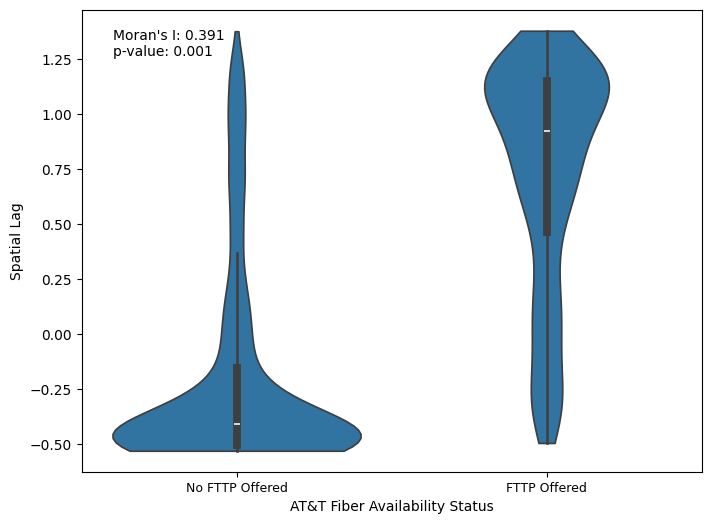

In [13]:
# Moran Plot -> variable of interest is displayed against its spatial lag
    # not typically done with binary data, but may be interesting in terms of results
# see resource: https://lanselin.github.io/introbook_vol1/morans-i.html


plt.figure(figsize=(8, 6))
seaborn.violinplot(x=scraped_data["has_FTTH_std"], y=scraped_data["has_FTTH_lag_std"], data=scraped_data,
                  inner='box', cut = 0)
plt.xlabel('AT&T Fiber Availability Status')
plt.xticks([0, 1], ['No FTTP Offered', 'FTTP Offered'], fontsize=9)
plt.ylabel('Spatial Lag')
#plt.title("Distribution of Spatial Lags by FTTP Availability (Binary)")

moran = esda.Moran(scraped_data["has_FTTH"], w_adapt)
plt.text(0.05, 0.9, f"Moran's I: {moran.I:.3f}\np-value: {moran.p_sim:.3f}", transform=plt.gca().transAxes)


plt.show()


#### Step 5: Local Autocorrelation
- goal: identify cases in which the value of an observation and the average if its surroundings is more similar (indicates cluster) or dissimilar (indicates outlier) that what we would expect under spatial randomness

In [14]:
loc_moran = esda.moran.Moran_Local(scraped_data["has_FTTH"], w_adapt)

<Axes: ylabel='Density'>

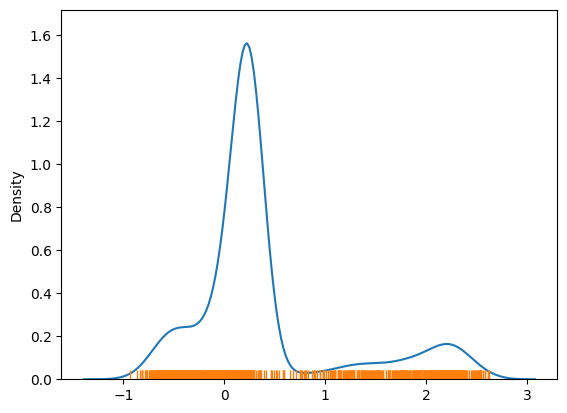

In [15]:
#plot distribution of local indicators

# Draw KDE line --> More info: https://seaborn.pydata.org/generated/seaborn.kdeplot.html
ax = seaborn.kdeplot(loc_moran.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(loc_moran.Is, ax=ax)

# clear skew towards positive autocorrelation/clustering of similar observations (x-axis represents local moran value for each observation)

In [16]:
scraped_data=scraped_data.assign(local_moran=loc_moran.Is)
scraped_data=scraped_data.assign(local_moran_p=loc_moran.p_sim)
scraped_data=scraped_data.assign(quadrant=loc_moran.q)

In [17]:
display(scraped_data[scraped_data['local_moran_p'] < 0.05])

,address_ID,address,lat,lon,block_geoid,population,population_error,has_FTTH,geometry,has_FTTH_lag,has_FTTH_std,has_FTTH_lag_std,local_moran,local_moran_p,quadrant
0,10886721,"7331 North HONORE Street, CHICAGO, IL 60626",42.014683,-87.676228,170310102012,1621.0,818.0,0,POINT (-87.676 42.015),0.000000,-0.529113,-0.530717,0.279853,0.001,3
1,10888120,"7411 North CLARK Street, CHICAGO, IL 60626",42.016408,-87.675060,170310102021,1354.0,306.0,0,POINT (-87.675 42.016),0.000000,-0.529113,-0.530717,0.279853,0.001,3
2,10889247,"7308 North PAULINA Street, CHICAGO, IL 60626",42.014176,-87.672644,170310102022,1511.0,471.0,0,POINT (-87.673 42.014),0.000000,-0.529113,-0.530717,0.279853,0.001,3
3,10890447,"7589 North SHERIDAN Road, CHICAGO, IL 60626",42.019106,-87.665409,170310103002,2819.0,1008.0,0,POINT (-87.665 42.019),0.000000,-0.529113,-0.530717,0.279853,0.001,3
4,10890425,"7579 North SHERIDAN Road, CHICAGO, IL 60626",42.019088,-87.665409,170310103002,2819.0,1008.0,0,POINT (-87.665 42.019),0.000000,-0.529113,-0.530717,0.279853,0.001,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2599,10857493,"3583 West PETERSON Avenue, CHICAGO, IL 60659",41.989980,-87.718564,170311303002,703.0,195.0,0,POINT (-87.719 41.990),0.333245,-0.529113,0.274055,-0.146523,0.007,2
2602,10846179,"5607 North SAINT LOUIS Avenue, CHICAGO, IL 60659",41.983289,-87.715969,170311303004,2101.0,570.0,0,POINT (-87.716 41.983),0.338289,-0.529113,0.286237,-0.152978,0.008,2
2603,10822730,"4957 North WHIPPLE Street, CHICAGO, IL 60625",41.971980,-87.704690,170311401001,1784.0,559.0,0,POINT (-87.705 41.972),0.401635,-0.529113,0.439214,-0.234026,0.001,2
2604,10821881,"4928 North WHIPPLE Street, CHICAGO, IL 60625",41.971166,-87.705152,170311401001,1784.0,559.0,1,POINT (-87.705 41.971),0.413236,1.889955,0.467232,0.888947,0.001,1


In [18]:
print(scraped_data.local_moran.max())
print(scraped_data.local_moran.min())

2.6176242007588955
-0.9326569657087516


In [19]:
scraped_gdf_viz = scraped_data.to_crs(epsg=4326) #CONVERT EPSG FOR EASIER VISUALIZATION
significant_data = scraped_gdf_viz[scraped_gdf_viz["local_moran_p"]< 0.05].copy()

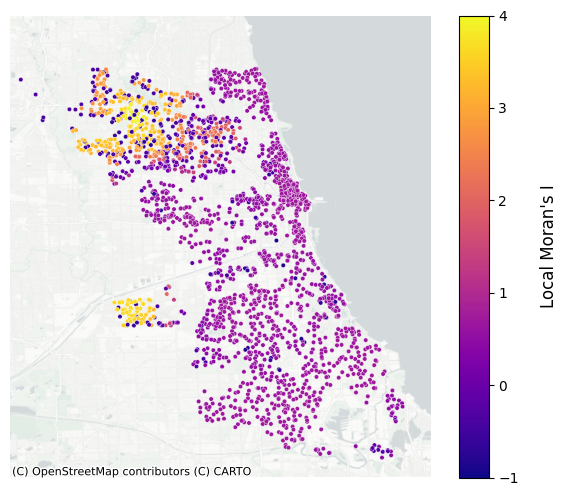

In [20]:

# Create a scatter plot
fig, ax = plt.subplots(figsize=(6, 6))


# Create a scatter showing local moran values at each location

scatter_plot = seaborn.scatterplot(
    x="lon", y="lat", data=significant_data, hue="local_moran", s=10, palette="plasma", legend=False
)

# Add colorbar

cax = fig.add_axes([ax.get_position().x1 + 0.01,  # Position to the right
                    ax.get_position().y0,         # Align with bottom of main plot
                    0.05,                         # Width of color bar
                    ax.get_position().height])    # same height as main plot

norm = plt.Normalize(vmin=-1, vmax=4)
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Local Moran\'s I', fontsize=12, labelpad=15)


# Add the basemap
cx.add_basemap(
    scatter_plot, crs="EPSG:4326", source=cx.providers.CartoDB.PositronNoLabels, zoom = 12
)

# # Zoom in on the map by setting x and y limits
scatter_plot.set_xlim([-87.9, -87.50])  # Longitude limits
scatter_plot.set_ylim([41.63, 42.07])    # Latitude limits


# Remove the axes labels if desired
scatter_plot.set_xlabel('')
scatter_plot.set_ylabel('')

scatter_plot.set_axis_off() 


plt.show()


In [26]:
sig_q_counts = pd.value_counts(significant_data["quadrant"])
print(sig_q_counts)

quadrant
3    1510
1     454
2     326
4      62
Name: count, dtype: int64


/var/folders/q_/hxs6bprd6qz5xsd01jm_081h0000gn/T/ipykernel_85315/1687813741.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  sig_q_counts = pd.value_counts(significant_data["quadrant"])


In [27]:
# number of values in each quadrant (should add up to number of census block groups/observations)
# Q1 = HH, Q2 = LH, Q3 = LL, Q4 = HL

q_counts = pd.value_counts(loc_moran.q)
print(q_counts) # adds up to 2606


# percentage of polygons/spatial units with significant local moran's I
percent_sig = (loc_moran.p_sim < 0.05).sum() * 100 / len(loc_moran.p_sim)
print(percent_sig) # about 33% of census blocks considered to be part of (or an outlier within) a spatial cluster

3    1615
1     491
2     421
4      79
Name: count, dtype: int64
90.25326170376056


/var/folders/q_/hxs6bprd6qz5xsd01jm_081h0000gn/T/ipykernel_85315/1537992531.py:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  q_counts = pd.value_counts(loc_moran.q)


In [28]:
# plot histogram and compare to FCC data
fcc_q_dict = {"Low Low": 1155, "High High": 515, "High Low":121, "Low High":115}
scr_q_dict = {"Low Low": 1513, "High High": 454, "High Low":324, "Low High":62}

fcc_q_df = pd.DataFrame(list(fcc_q_dict.items()), columns=['Label', 'FCC_Count'])
scr_q_df = pd.DataFrame(list(scr_q_dict.items()), columns=['Label', 'SCR_Count'])

merged_df = pd.merge(fcc_q_df, scr_q_df, on='Label')

display(merged_df)

,Label,FCC_Count,SCR_Count
0,Low Low,1155,1513
1,High High,515,454
2,High Low,121,324
3,Low High,115,62


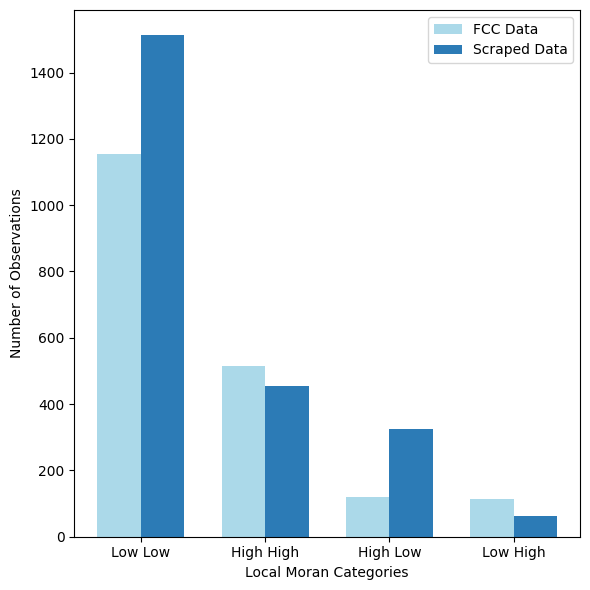

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
labels = merged_df['Label']
fcc_counts = merged_df['FCC_Count']
scr_counts = merged_df['SCR_Count']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(6, 6))
rects1 = ax.bar(x - width/2, fcc_counts, width, label='FCC Data', color = "#ABD9E9")
rects2 = ax.bar(x + width/2, scr_counts, width, label='Scraped Data', color = "#2C7BB6")

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Local Moran Categories')
ax.set_ylabel('Number of Observations')
#ax.set_title('Counts by label for FCC and SCR datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Improve layout
fig.tight_layout()

# Display the plot
plt.show()


In [30]:
#plot Local autocorrelation map over census block boundaries (significant data points)
fcc_full = gpd.read_file("fcc_data.geojson")

In [31]:
fcc_full =fcc_full.to_crs(4326)

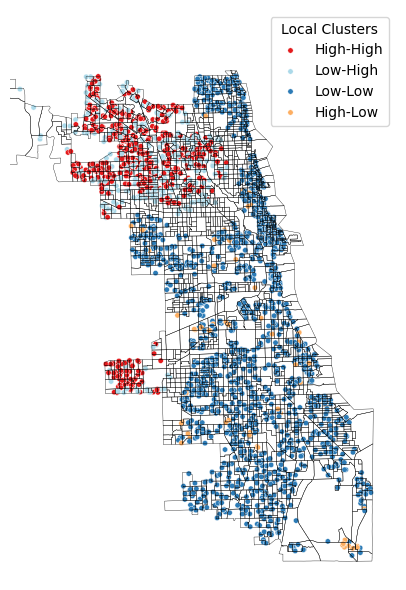

In [34]:
fig, ax = plt.subplots(figsize=(6, 6))

#fcc_full.boundary.plot(ax = ax, edgecolor ="black", linewidth = 0.5)
# Add basemap (Chicago Census Block Groups)
fcc_full.boundary.plot(ax = ax, edgecolor ="black", linewidth = 0.25)

# Define color scheme
#colors = {'HH': 'red', 'LL': 'blue', 'LH': 'lightblue', 'HL': 'pink', 'ns': 'lightgrey'}
colors = {1: "#E41A1C", 2: "#ABD9E9", 3: "#2C7BB6", 4: "#FDAE61"}
labels = {1: 'High-High', 2: 'Low-High', 3: 'Low-Low', 4: 'High-Low'}
color_palette = [colors[i] for i in range(1, 5)]

# Plot points
scatter =  seaborn.scatterplot (x="lon", y="lat", data=significant_data, hue="quadrant", s=15, hue_order = [1,2,3,4], palette=color_palette, legend="full", ax=ax, alpha = 1) 


# # Add basemap (Chicago Census Block Groups)
# fcc_full.boundary.plot(ax = ax, edgecolor ="black", linewidth = 0.25)

# # Zoom in on the map by setting x and y limits
scatter.set_xlim([-87.9, -87.50])  # Longitude limits
scatter.set_ylim([41.63, 42.07])    # Latitude limits


# Remove the axes labels if desired
scatter.set_xlabel('')
scatter.set_ylabel('')

scatter.set_axis_off() 

handles, _ = scatter.get_legend_handles_labels()
ax.legend(handles, [labels[i] for i in range(1, 5)], 
          title="Local Clusters", loc="upper right")

plt.tight_layout()
plt.show()